In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps
import PIL
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from ansim_dataset import ansimDataset, create_circular_mask
# from convolution_lstm import encoderConvLSTM, decoderConvLSTM
from ConvLSTM import ConvLSTM
import random
import math
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import time
import os
import scipy.ndimage
import cv2
import scipy.misc

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
img_path = '/home/rliu/ansim/data/data/JPEGImages/'
img_list_csv = '/home/rliu/github/ansim/img_list.csv'
train_csv = '/home/rliu/github/ansim/train.csv'
test_csv = '/home/rliu/github/ansim/test.csv'
output_path = '/home/rliu/ansim/models/very_first.pt'

In [4]:
mask = create_circular_mask(128,128)

testset = ansimDataset(img_list_csv = img_list_csv, seq_csv = test_csv, root_dir = img_path, step=20, random_rotate = True, transform=None, image_size=128)
testloader = torch.utils.data.DataLoader(testset,
                                             batch_size=1, shuffle=False,
                                             num_workers=1)

In [5]:
model = torch.load('/home/rliu/ansim/models/4-22_22-3x3/0200.weights').cuda()

In [6]:
print(model)

DataParallel(
  (module): ConvLSTM(
    (activateConv): Conv2d(640, 1, kernel_size=(1, 1), stride=(1, 1))
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(33, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): ConvLSTMCell(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): ConvLSTMCell(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): ConvLSTMCell(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (5): ConvLSTMCell(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (6): ConvLSTMCell(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (7): ConvLSTMCell(
        (conv): Conv2d(64, 1

In [6]:

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("GPU in use")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.MSELoss()
with torch.no_grad():
    running_loss_test = 0.0
    loss_by_class = 0.0
    test_iter = 0
    for data in testloader:
        test_iter += 1
        data_split = torch.split(data, int(data.shape[1]/2), dim=1)
        inputs = data_split[0]
        target = data_split[1]


        if use_gpu:
            inputs, target = inputs.to(device), target.to(device)
        else:
            inputs, target = Variable(inputs), Variable(target)


        _, _, predicted = model(inputs)


        loss_test = criterion(predicted, target)
        iter_loss_test = loss_test.item()
        running_loss_test += loss_test.item()    
        epoch_loss_test = running_loss_test / len(testset)
        loss_by_class += loss_test.item()
        if test_iter == 37:
            print('Loss on the 1-37: %.5f ' % (loss_by_class/37.0))
            loss_by_class = 0.0
        elif test_iter == 117:
            print('Loss on the 38-117: %.5f ' % (loss_by_class/80.0))
            loss_by_class = 0.0
        elif test_iter == 150:
            print('Loss on the 118-150: %.5f ' % (loss_by_class/33.0))
            loss_by_class = 0.0
        elif test_iter == 215:
            print('Loss on the 151-215: %.5f ' % (loss_by_class/65.0))
            loss_by_class = 0.0
        epoch_loss_test = running_loss_test / len(testset)

print('Loss on the test images: %.5f ' % (
    epoch_loss_test))

GPU in use
Loss on the 1-37: 53.82444 
Loss on the 38-117: 397.60973 
Loss on the 118-150: 375.83333 
Loss on the 151-215: 106.94677 
Loss on the test images: 247.22941 


In [6]:
dataiter = iter(testloader)
for i in range(163):
    images = dataiter.next()
data_split = torch.split(images, int(images.shape[1]/2), dim=1)
inputs_t = data_split[0]
target_t = data_split[1]

inputs_t, target_t = inputs_t.cuda(), target_t.cuda()

_, _, predicted_t = model(inputs_t)

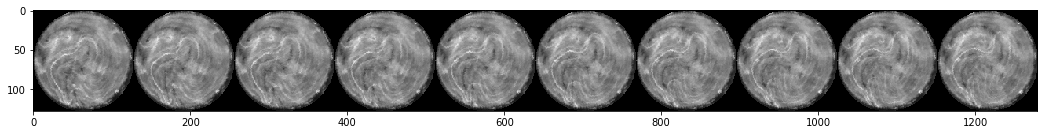

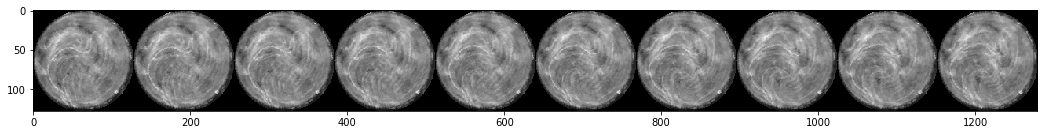

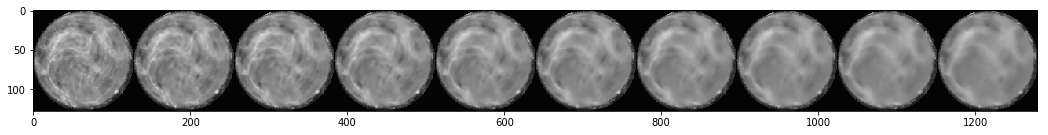

In [7]:
predicted = predicted_t[0,:,0,:,:].cpu().detach().numpy()

target = target_t[0,:,0,:,:].cpu().detach().numpy()

inputs = inputs_t[0,:,0,:,:].cpu().detach().numpy()

inputs = inputs.reshape(1280,128).transpose().astype(int)
target = target.reshape(1280,128).transpose().astype(int)
predicted = predicted.reshape(1280,128).transpose().astype(int)

inputs = inputs - inputs.min()
target = target - target.min()
predicted = predicted - predicted.min()

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(inputs, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(target, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(predicted, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

# plt.savefig('/home/rliu/ansim/results/inputs.jpg')

In [ ]:
predicted = predicted_t[0,:,0,:,:].cpu().detach().numpy().astype(int)
target = target_t[0,:,0,:,:].cpu().detach().numpy().astype(int)
inputs = inputs_t[0,:,0,:,:].cpu().detach().numpy().astype(int)
inputs = inputs - inputs.min()
target = target - target.min()
predicted = predicted - predicted.min()

In [ ]:
for i in range(10):
    output_path = '/home/rliu/ansim/results/4-20_18-3x3/t163/input%0.2d.jpg' % (i+1)
    plt.imshow(inputs[i],cmap = 'gray')
    plt.savefig(output_path)
    
for i in range(10):
    output_path = '/home/rliu/ansim/results/4-20_18-3x3/t163/target%0.2d.jpg' % (i+1)
    plt.imshow(target[i],cmap = 'gray')
    plt.savefig(output_path)
    
for i in range(10):
    output_path = '/home/rliu/ansim/results/4-20_18-3x3/t163/predicted%0.2d.jpg' % (i+1)
    plt.imshow(predicted[i],cmap = 'gray')
    plt.savefig(output_path)



In [23]:
'/home/rliu/ansim/results/input%0.2d.jpg' % 5

'/home/rliu/ansim/results/input05.jpg'

In [1]:
scipy.misc.imsave('1.jpg', predicted[0])

NameError: name 'scipy' is not defined

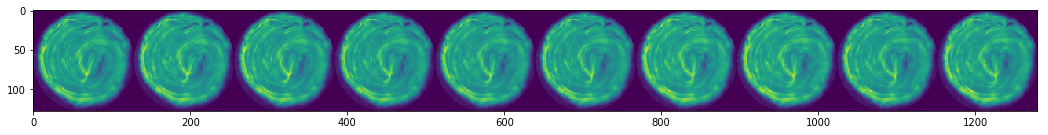

In [62]:
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(inputs, interpolation='nearest',shape=(128,1280))
plt.savefig('/home/rliu/ansim/models/inputs.jpg')

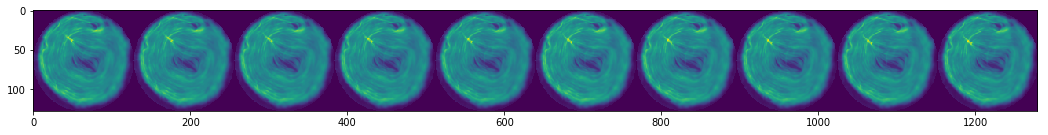

In [55]:
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(target, interpolation='nearest',shape=(128,1280))
plt.savefig('/home/rliu/ansim/models/target.jpg')

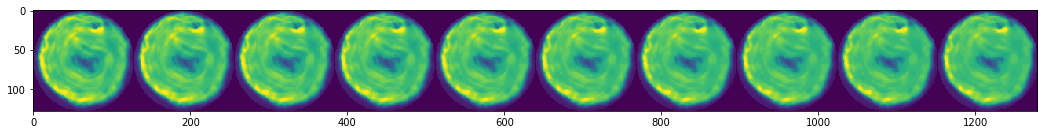

In [57]:
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(predicted, interpolation='nearest',shape=(128,1280))
plt.savefig('/home/rliu/ansim/models/predicted.jpg')

In [ ]:
np.transpose(predicted,(1,2,0))

In [1]:
import numpy as np
from PIL import Image

# gradient between 0 and 1 for 256*256
array = np.linspace(0,1,256*256)

# reshape to 2d
mat = np.reshape(array,(256,256))

# Creates PIL image
img = Image.fromarray( mat , 'L')
img.show()

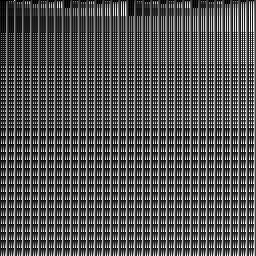

In [2]:
img